In [15]:
#libraries and data
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
import seaborn as sns 
from sklearn.linear_model import LinearRegression


In [16]:
#Classes to process the data
class State(object):
  def __init__(self, state, new_cases_per_100k, dem_margin):
    self.state = state
    self.cases = new_cases_per_100k
    self.dem_margin = dem_margin 
  
  def toString(self):
    return f"State: {self.state}, New Weekly Cases Per 100k: {self.cases}, Democratic Margin of Victory: {self.dem_margin}"

class Container(object):
  def __init__(self):
    self.states = []
  
  def add(self, state):
    self.states.append(state)
  
  def toString(self):
    string = ''
    for item in self.states:
      string += item.toString() + "\n"
    return string

In [17]:
#Covid Data 
cov_key = "2c3b686a09214915b1471a2f0df00d20"
cov_url = "https://api.covidactnow.org/v2/states.json?apiKey="+cov_key

#Get data
cov_data = req.get(cov_url).json()

#Create dataframe
df = pd.DataFrame(cov_data)
state_covid_data = {}

for row in df.iterrows():
  state_covid_data[row[1].state] = row[1].metrics["weeklyNewCasesPer100k"]

In [18]:
#Voting Data 
vote_data = pd.read_csv(r'../data/pop_vote2.csv')

#Make a dictionary with the states as keys and the democratic margin as values
vote_dict_names = dict(zip(vote_data['state'], vote_data['dem_this_margin']))

#Dict of abbreviations and full names
state_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
#Reverse the list to use the name to find the variables 
#inv_map = {v: k for k, v in my_map.items()}
state_dict = {v:k for k, v in state_dict.items()}

vote_dict_abbrev = {}

#Rename the states to their abrev
for item in vote_dict_names:
    try:
        abbrev = state_dict[item]
        vote_dict_abbrev[abbrev] = vote_dict_names[item]
    except:
        continue

In [20]:
#Put all the data into a container object
container = Container()

for item in vote_dict_abbrev:
    state_obj = State(state=item, dem_margin=vote_dict_abbrev[item], new_cases_per_100k=state_covid_data[item])
    container.add(state_obj)

print(container.toString())

State: AZ, New Weekly Cases Per 100k: 37.8, Democratic Margin of Victory: 0.3%
State: FL, New Weekly Cases Per 100k: None, Democratic Margin of Victory: -3.4%
State: GA, New Weekly Cases Per 100k: 77.3, Democratic Margin of Victory: 0.2%
State: IA, New Weekly Cases Per 100k: 53.5, Democratic Margin of Victory: -8.2%
State: MI, New Weekly Cases Per 100k: 96.0, Democratic Margin of Victory: 2.8%
State: MN, New Weekly Cases Per 100k: 46.9, Democratic Margin of Victory: 7.1%
State: NV, New Weekly Cases Per 100k: 41.0, Democratic Margin of Victory: 2.4%
State: NH, New Weekly Cases Per 100k: 88.0, Democratic Margin of Victory: 7.4%
State: NC, New Weekly Cases Per 100k: 150.1, Democratic Margin of Victory: -1.3%
State: OH, New Weekly Cases Per 100k: 68.1, Democratic Margin of Victory: -8.0%
State: PA, New Weekly Cases Per 100k: 86.3, Democratic Margin of Victory: 1.2%
State: TX, New Weekly Cases Per 100k: 70.5, Democratic Margin of Victory: -5.6%
State: WI, New Weekly Cases Per 100k: 75.1, De

Text(0, 0.5, 'Margin of Democratic Victory in the 2022 Election')

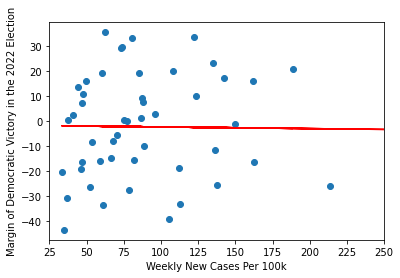

In [41]:
#Make a plot for the data 

# Make two arrays, one for the dem_margin_vic and one for the cases 
dem_margin = []
cases_per_100k = []

for item in container.states:
  if item.cases == None: 
    continue
  else: 
    cases_per_100k.append(item.cases)
    dem_margin.append(item.dem_margin)
  
# print(dem_margin)

dem_float_arr = []

for item in dem_margin:
   dem_float_arr.append(float(item.replace("%", "")))


# linear line     
X = pd.DataFrame(cases_per_100k).values
Y = pd.DataFrame(dem_float_arr).values
linear = LinearRegression()
linear.fit(X, Y)
y_pred = linear.predict(X)

plt.figure(0)
plt.scatter(cases_per_100k, dem_float_arr)


#set the scale of the x axis 
plt.xlim(25, 250)
plt.plot(X, y_pred, color='red') 
plt.xlabel("Weekly New Cases Per 100k")
plt.ylabel("Margin of Democratic Victory in the 2022 Election")
